In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import kaggle 
#! kaggle datasets download -d kapilverma/uk-energy-trading

#import zipfile as zp
#zip_ref = zp.ZipFile('uk-energy-trading.zip')
#zip_ref.extractall()
#zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/kapilverma/uk-energy-trading
License(s): ODbL-1.0
  0%|                                               | 0.00/1.09M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.09M/1.09M [00:00<00:00, 867MB/s]


In [3]:
auc_df = pd.read_csv('CSV/auction_data.csv',delimiter=';')
auc_df.head()

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction
0,NaN,GBP/MWh,GBP/MWh,MW,MW,GBP/MWh
1,[01/01/2021 00:00],68,65.73,2923.7,5102.4,54.19
2,[01/01/2021 01:00],62.7,64.96,2825,4771.5,53.42
3,[01/01/2021 02:00],56,60.47,2611.4,4176.2,50.13
4,[01/01/2021 03:00],50.1,52.5,2669.3,3755.9,50.28


In [4]:
auc_df = auc_df[1:]
auc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14879 entries, 1 to 14879
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date (WET)                    14879 non-null  object
 1   price_first_auction           14879 non-null  object
 2   price_second_auction          14879 non-null  object
 3   traded_volume_first_auction   14879 non-null  object
 4   traded_volume_second_auction  14877 non-null  object
 5   price_forecast_first_auction  14831 non-null  object
dtypes: object(6)
memory usage: 697.6+ KB


In [11]:
auc_df['Date (WET)'] = auc_df['Date (WET)'].apply(lambda x: (datetime.strptime(x, '[%d/%m/%Y %H:%M]')))
auc_df[auc_df.columns[1:]] = auc_df[auc_df.columns[1:]].apply(lambda x: pd.to_numeric(x))
auc_df.head()

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction
1,2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19
2,2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42
3,2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13
4,2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28
5,2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19


In [12]:
auc_df=auc_df.dropna(how='all')

auc_df.duplicated().sum()

np.int64(0)

In [13]:
def get_null_cols(df):
    null_dict = {}
    for i in df.columns:
        if df[i].isnull().sum()>0:
            null_dict[i] = df[i].isnull().sum()
    return null_dict

get_null_cols(auc_df)

{'traded_volume_second_auction': np.int64(2),
 'price_forecast_first_auction': np.int64(48)}

In [14]:
auc_df[auc_df.isnull().any(axis=1)].head(10)

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction
1537,2021-03-06 00:00:00,53.3,52.93,3190.4,7455.2,NaN
1538,2021-03-06 01:00:00,52.4,49.08,3093.5,7170.2,NaN
1539,2021-03-06 02:00:00,48.5,48.55,3152.6,6924.2,NaN
1540,2021-03-06 03:00:00,45.0,46.90,3164.6,6688.0,NaN
1541,2021-03-06 04:00:00,45.0,43.55,3460.0,6738.8,NaN
1542,2021-03-06 05:00:00,46.0,43.60,3394.4,6863.3,NaN
1543,2021-03-06 06:00:00,50.0,51.36,3551.3,7109.6,NaN
1544,2021-03-06 07:00:00,52.7,50.00,3521.8,6976.8,NaN
1545,2021-03-06 08:00:00,57.8,55.00,3866.3,7319.9,NaN
1546,2021-03-06 09:00:00,61.0,65.13,3906.3,7932.7,NaN


In [15]:
ref_df = pd.DataFrame(columns=['ref','tar'])
ref_df['ref'] = auc_df['price_forecast_first_auction'][:1500]
ref_df['tar'] = auc_df['price_forecast_first_auction'][:1476]
ref_df

,ref,tar
1,54.19,54.19
2,53.42,53.42
3,50.13,50.13
4,50.28,50.28
5,47.19,47.19
...,...,...
1496,64.43,NaN
1497,71.53,NaN
1498,72.68,NaN
1499,71.35,NaN


In [16]:
def search_filling_method(ref_df):
    ref_df = ref_df.assign(Rollavg=ref_df.tar.fillna(ref_df.tar.rolling(25,min_periods=1,).mean()))
    ref_df = ref_df.assign(RollMedian=ref_df.tar.fillna(ref_df.tar.rolling(25,min_periods=1,).median()))
    ref_df = ref_df.assign(InterpolateSpline3=ref_df.tar.interpolate(method='spline', order=3))
    ref_df = ref_df.assign(InterpolateSpline4=ref_df.tar.interpolate(method='spline', order=4))
    ref_df = ref_df.assign(InterpolateSpline5=ref_df.tar.interpolate(method='spline', order=5))

    results = [(method, np.sqrt(metrics.mean_squared_error(ref_df.ref, ref_df[method]))) 
               for method in list(ref_df)[2:]]
    results_df = pd.DataFrame(np.array(results), columns=['Method', 'RMSE'])
    results_df.sort_values(by='RMSE', ascending=False)
    return results_df
results_df = search_filling_method(ref_df)
results_df

,Method,RMSE
0,Rollavg,6.637092702431262
1,RollMedian,6.986361141538562
2,InterpolateSpline3,16491.599722406107
3,InterpolateSpline4,198115.55081577832
4,InterpolateSpline5,11125436.832408043


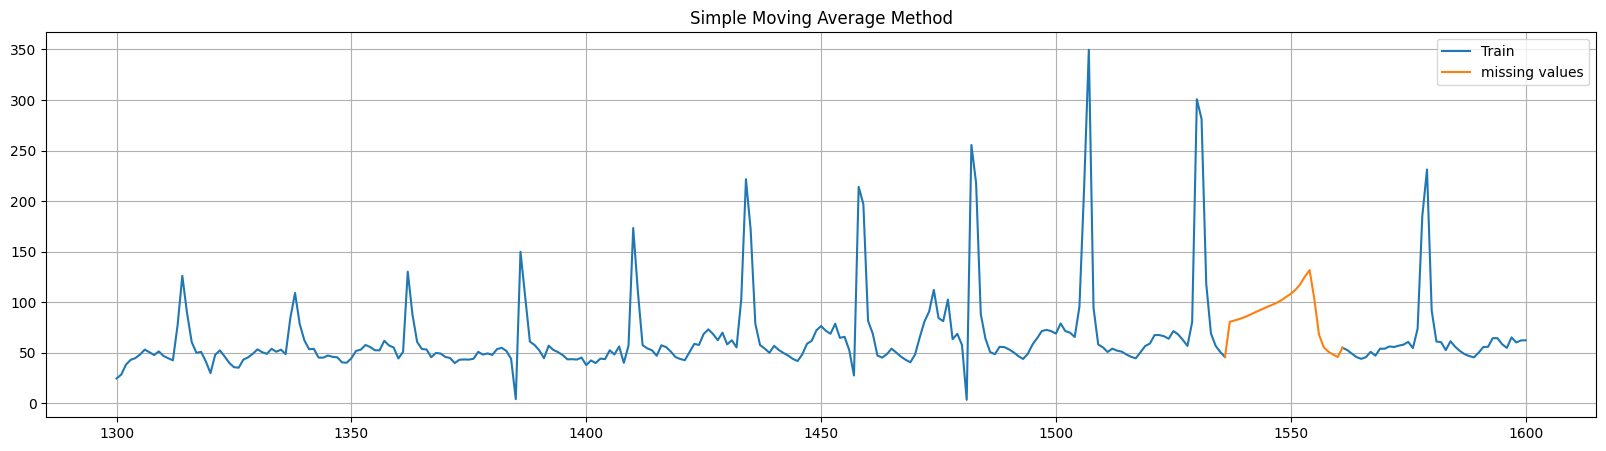

In [17]:
#Simple moving average method 
y_pred =auc_df.copy()
y_pred['price_forecast_first_auction'] = auc_df.price_forecast_first_auction.fillna(
    auc_df.price_forecast_first_auction.rolling(25,min_periods=1,).mean())

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auc_df['price_forecast_first_auction'].loc[1300:1600], label='Train')
plt.plot(y_pred['price_forecast_first_auction'].loc[1536:1561], label='missing values')
plt.legend(loc='best')
plt.title('Simple Moving Average Method');

In [18]:
auc_df.price_forecast_first_auction = auc_df.price_forecast_first_auction.fillna(
                                      auc_df.price_forecast_first_auction.rolling(25,min_periods=1,).mean())
auc_df = auc_df.bfill()
get_null_cols(auc_df)

{}

In [20]:
def read_preprocess(filepath):
    df = pd.read_csv(filepath,delimiter=';')
    df = df[1:]
    df['Date (WET)'] = df['Date (WET)'].apply(lambda x: (datetime.strptime(x, '[%d/%m/%Y %H:%M]')))
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x: pd.to_numeric(x,errors='coerce'))
    df = df.dropna(how='all')
    print(f'Duplicate rows:{df.duplicated().sum()}')
    print(f'Null Values:{get_null_cols(df)}')
    return df

sys_df = read_preprocess('system_prices.csv')
print('\n')
sys_df.head()

Duplicate rows:0
Null Values:{'forecast_system_price_low': np.int64(48), 'forecast_system_price_high': np.int64(48), 'system_price': np.int64(44)}




,Date (WET),forecast_system_price_low,forecast_system_price_high,system_price
1,2021-01-01 00:00:00,48.33,44.89,73.15
2,2021-01-01 01:00:00,54.35,53.26,71.95
3,2021-01-01 02:00:00,32.66,65.86,54.56
4,2021-01-01 03:00:00,41.55,63.43,70.73
5,2021-01-01 04:00:00,26.62,66.91,54.98


In [21]:
sys_df[sys_df.isnull().any(axis=1)].loc[1500:1550]

,Date (WET),forecast_system_price_low,forecast_system_price_high,system_price
1537,2021-03-06 00:00:00,NaN,NaN,42.40
1538,2021-03-06 01:00:00,NaN,NaN,42.60
1539,2021-03-06 02:00:00,NaN,NaN,56.65
1540,2021-03-06 03:00:00,NaN,NaN,55.95
1541,2021-03-06 04:00:00,NaN,NaN,55.93
1542,2021-03-06 05:00:00,NaN,NaN,55.95
1543,2021-03-06 06:00:00,NaN,NaN,55.90
1544,2021-03-06 07:00:00,NaN,NaN,54.65
1545,2021-03-06 08:00:00,NaN,NaN,62.73
1546,2021-03-06 09:00:00,NaN,NaN,86.00


In [22]:
ref_df = pd.DataFrame(columns=['ref','tar'])
ref_df['ref'] = sys_df['system_price'][:600]
ref_df['tar'] = sys_df['system_price'][:576]
search_filling_method(ref_df)

,Method,RMSE
0,Rollavg,5.300130320679532
1,RollMedian,5.164011352621139
2,InterpolateSpline3,44738.99872450196
3,InterpolateSpline4,684457.1159529577
4,InterpolateSpline5,37620291.62669144


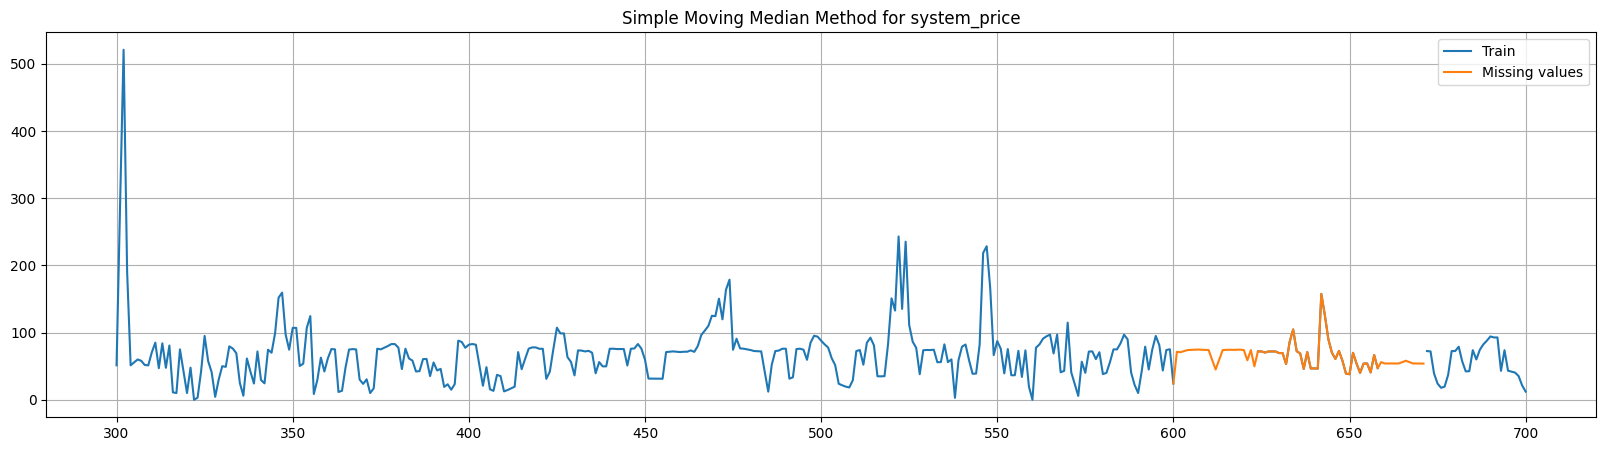

In [23]:
#Simple moving median method 
y_pred =sys_df.copy()
y_pred['system_price'] = sys_df.system_price.fillna(
    sys_df.system_price.rolling(25,min_periods=1,).median())

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(sys_df['system_price'].loc[300:700], label='Train')
plt.plot(y_pred['system_price'].loc[600:671], label='Missing values')
plt.legend(loc='best')
plt.title('Simple Moving Median Method for system_price');

#filling missing values
sys_df.system_price = sys_df.system_price.fillna(
    sys_df.system_price.rolling(25,min_periods=1,).median())

In [24]:
def miss_val_fill_method(df,u_index,l_index):
    miss_val_fill_methods = {}
    miss_val_cols = [i for i in get_null_cols(df) if get_null_cols(df)[i]>5]
    for col_name in miss_val_cols:
        ref_df = pd.DataFrame(columns=['ref','tar'])
        ref_df['ref'] = df[col_name][:u_index]
        ref_df['tar'] = df[col_name][:l_index]
        results_df = search_filling_method(ref_df)
        miss_val_fill_methods[col_name] = results_df.Method[0]
    return miss_val_fill_methods

result_dict= miss_val_fill_method(sys_df,1500,1476)
print(result_dict)
print('\n')

for col in result_dict.keys():
    print(f'missing values filled in {col}')
    sys_df[col] = sys_df[col].fillna(sys_df[col].rolling(25,min_periods=1,).mean())
sys_df = sys_df.bfill()
get_null_cols(sys_df)

{'forecast_system_price_low': 'Rollavg', 'forecast_system_price_high': 'Rollavg'}


missing values filled in forecast_system_price_low
missing values filled in forecast_system_price_high


{}

In [25]:
for_df = read_preprocess('forecast_inputs.csv')
print('\n')
for_df.head()

Duplicate rows:0
Null Values:{'demand_plus_system_margin': np.int64(1), 'margin': np.int64(1), 'long_term_solar': np.int64(49), 'long_term_solar_over_demand': np.int64(48), 'long_term_solar_over_margin': np.int64(48), 'margin_over_demand': np.int64(1), 'snsp_forecast': np.int64(48), 'stack_price': np.int64(1), 'previous_day_ahead_price': np.int64(84), 'previous_continuous_half_hour_vwap': np.int64(34)}




,Date (WET),demand_plus_system_margin,demand,within_day_availability,margin,within_day_margin,long_term_wind,long_term_solar,long_term_wind_over_demand,long_term_wind_over_margin,long_term_solar_over_demand,long_term_solar_over_margin,margin_over_demand,snsp_forecast,stack_price,within_day_potential_stack_price,previous_day_ahead_price,previous_continuous_half_hour_vwap,inertia_forecast
1,2021-01-01 00:00:00,56513.64,30182.0,40389.06,-26331.64,-15268.70,-3674.64,0.0,-12,-14,0.0,0.0,-87.0,29.95,67.79,68.88,65.02,59.69,214.67
2,2021-01-01 01:00:00,56506.94,29269.0,40389.06,-27237.94,-16191.00,-3667.94,0.0,-13,-14,0.0,0.0,-93.0,31.05,67.79,68.45,62.00,51.86,205.47
3,2021-01-01 02:00:00,56502.20,27245.0,40389.06,-29257.20,-18226.26,-3663.20,0.0,-14,-13,0.0,0.0,-108.0,32.80,67.73,67.79,54.16,46.29,191.12
4,2021-01-01 03:00:00,56487.24,25545.5,40389.06,-30941.74,-19935.30,-3648.24,0.0,-15,-12,0.0,0.0,-121.0,34.95,67.61,67.73,51.94,54.22,176.23
5,2021-01-01 04:00:00,56373.63,24180.0,40389.06,-32193.63,-21212.69,-3534.63,0.0,-15,-11,0.0,0.0,-134.0,36.70,66.48,67.67,49.17,57.26,163.59


In [26]:
result_dict = miss_val_fill_method(for_df,1500,1476)
result_dict

{'long_term_solar': 'Rollavg',
 'long_term_solar_over_demand': 'Rollavg',
 'long_term_solar_over_margin': 'Rollavg',
 'snsp_forecast': 'Rollavg',
 'previous_day_ahead_price': 'Rollavg',
 'previous_continuous_half_hour_vwap': 'Rollavg'}

In [27]:
for col in result_dict.keys():
    print(f'missing values filled in {col}')
    for_df[col] = for_df[col].fillna(for_df[col].rolling(25,min_periods=1,).mean())
for_df = for_df.bfill()
get_null_cols(for_df)

missing values filled in long_term_solar
missing values filled in long_term_solar_over_demand
missing values filled in long_term_solar_over_margin
missing values filled in snsp_forecast
missing values filled in previous_day_ahead_price
missing values filled in previous_continuous_half_hour_vwap


{}

In [28]:
for_df = for_df.join(auc_df[['Date (WET)','price_second_auction','traded_volume_second_auction']].set_index(
                    'Date (WET)'),on='Date (WET)')
for_df = for_df.bfill()
for_df.head()

,Date (WET),demand_plus_system_margin,demand,within_day_availability,margin,within_day_margin,long_term_wind,long_term_solar,long_term_wind_over_demand,long_term_wind_over_margin,...,long_term_solar_over_margin,margin_over_demand,snsp_forecast,stack_price,within_day_potential_stack_price,previous_day_ahead_price,previous_continuous_half_hour_vwap,inertia_forecast,price_second_auction,traded_volume_second_auction
1,2021-01-01 00:00:00,56513.64,30182.0,40389.06,-26331.64,-15268.70,-3674.64,0.0,-12,-14,...,0.0,-87.0,29.95,67.79,68.88,65.02,59.69,214.67,65.73,5102.4
2,2021-01-01 01:00:00,56506.94,29269.0,40389.06,-27237.94,-16191.00,-3667.94,0.0,-13,-14,...,0.0,-93.0,31.05,67.79,68.45,62.00,51.86,205.47,64.96,4771.5
3,2021-01-01 02:00:00,56502.20,27245.0,40389.06,-29257.20,-18226.26,-3663.20,0.0,-14,-13,...,0.0,-108.0,32.80,67.73,67.79,54.16,46.29,191.12,60.47,4176.2
4,2021-01-01 03:00:00,56487.24,25545.5,40389.06,-30941.74,-19935.30,-3648.24,0.0,-15,-12,...,0.0,-121.0,34.95,67.61,67.73,51.94,54.22,176.23,52.50,3755.9
5,2021-01-01 04:00:00,56373.63,24180.0,40389.06,-32193.63,-21212.69,-3534.63,0.0,-15,-11,...,0.0,-134.0,36.70,66.48,67.67,49.17,57.26,163.59,48.98,4047.5


In [29]:
for_df[for_df.describe().columns[1:]].skew(axis=0, skipna=True).sort_values(ascending=False)

previous_continuous_half_hour_vwap    6.046551
price_second_auction                  3.742994
previous_day_ahead_price              3.217815
within_day_potential_stack_price      1.696613
stack_price                           1.323437
demand_plus_system_margin             0.399509
snsp_forecast                         0.380093
inertia_forecast                      0.262795
demand                                0.176571
traded_volume_second_auction          0.148789
within_day_availability               0.081035
long_term_wind_over_margin           -0.149518
within_day_margin                    -0.304949
margin                               -0.364723
long_term_wind                       -0.434660
long_term_wind_over_demand           -0.716600
margin_over_demand                   -0.736933
long_term_solar                      -1.362301
long_term_solar_over_demand          -1.401543
long_term_solar_over_margin          -2.216577
dtype: float64

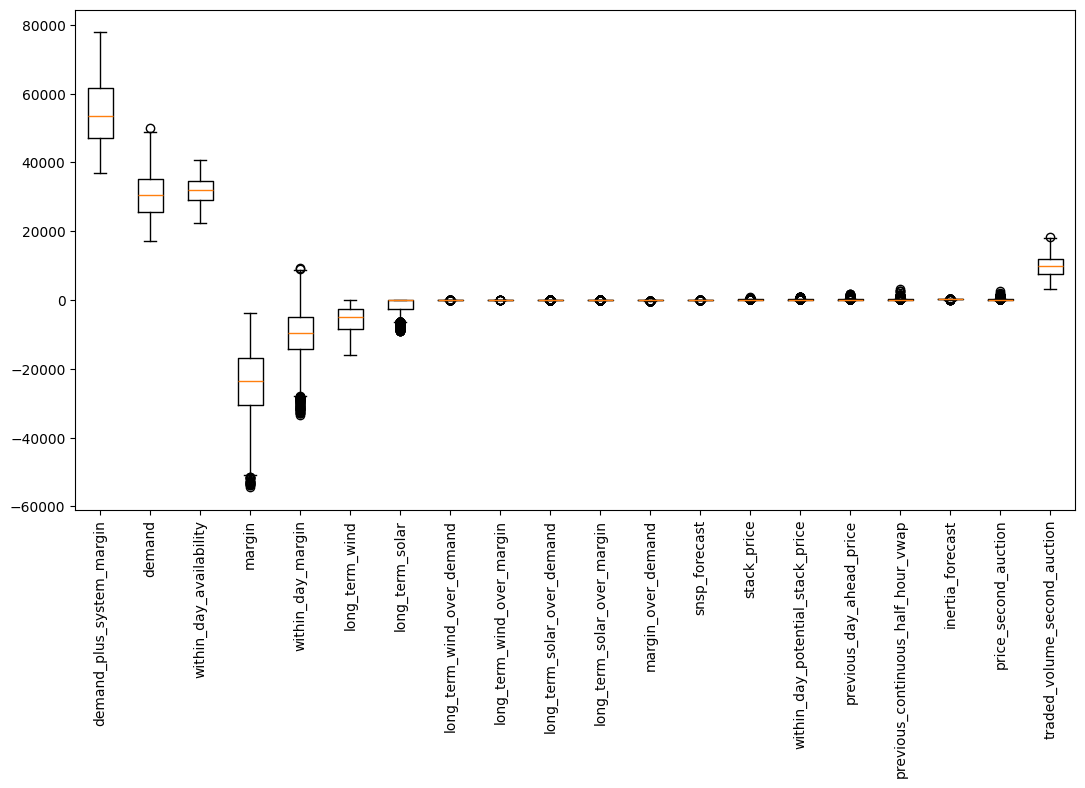

In [30]:
def draw_boxplot(df,cols):
    fig = plt.figure(figsize =(10, 5))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    # Creating plot
    bp = ax.boxplot(df[cols]);
    # x-axis labels
    ax.set_xticklabels(cols, rotation=90);
    
draw_boxplot(for_df,for_df.columns[1:])

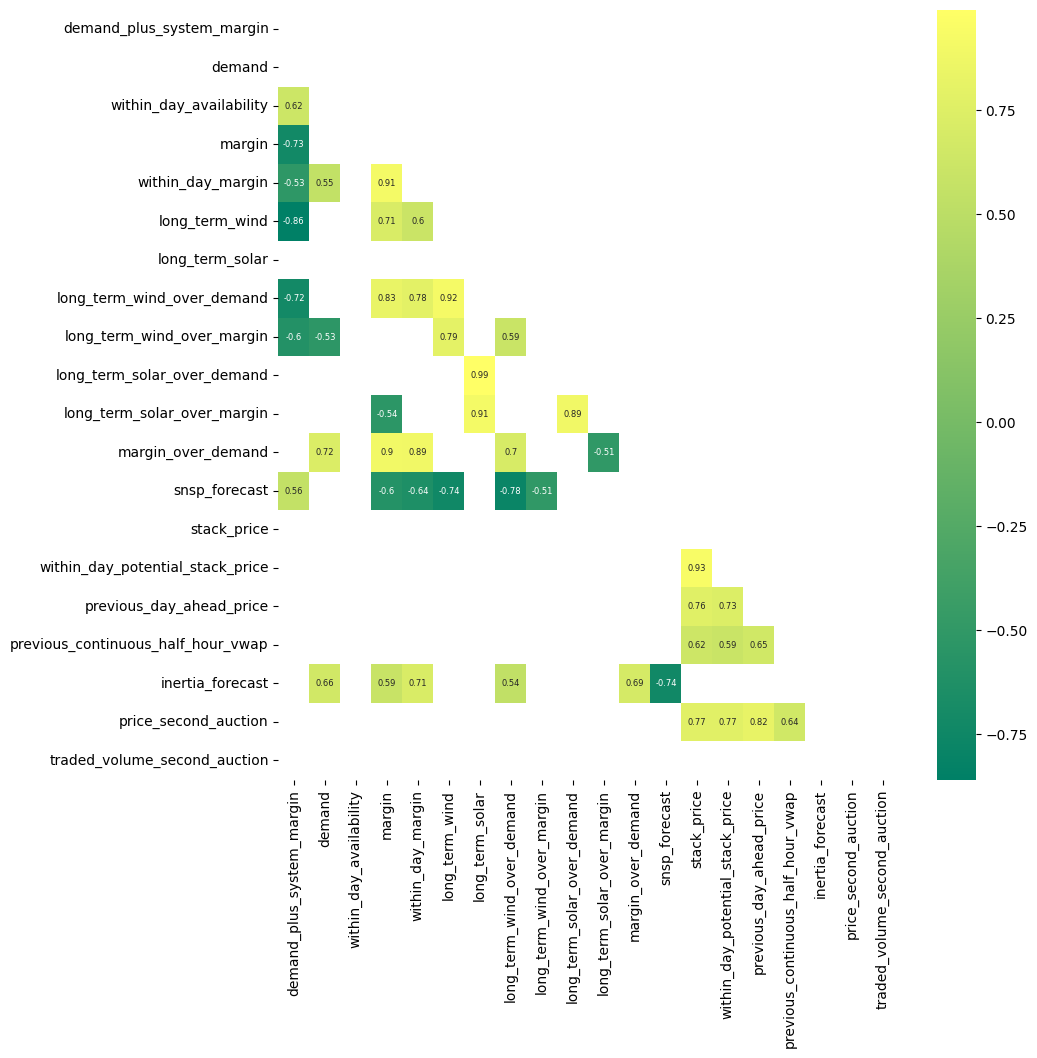

In [31]:
plt.figure(figsize=(10,10))
df_corr=for_df[for_df.columns[1:]].copy()
cor_df=df_corr.corr()
sns.heatmap(cor_df[(cor_df >= 0.5) | (cor_df <= -0.5)],annot=True,cmap='summer',mask = np.triu(cor_df),
            annot_kws={"fontsize":6});

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = for_df.columns[1:]
vif["vif_Factor"] = [variance_inflation_factor(np.array(for_df[for_df.columns[1:]].values, dtype=float), i) 
                     for i in range(for_df.shape[1]-1)]
vif[vif.vif_Factor>10].sort_values(by='vif_Factor',ascending=False)

,features,vif_Factor
0,demand_plus_system_margin,1.329747e+08
1,demand,4.238075e+07
3,margin,2.881784e+07
2,within_day_availability,5.196508e+03
4,within_day_margin,7.658918e+02
5,long_term_wind,6.635971e+02
17,inertia_forecast,2.592698e+02
11,margin_over_demand,2.518229e+02
7,long_term_wind_over_demand,1.948585e+02
6,long_term_solar,1.822924e+02


In [34]:
from sklearn.model_selection import train_test_split
feature_col_names = ['demand','within_day_availability', 'margin','long_term_wind', 
                     'long_term_solar', 'snsp_forecast','previous_day_ahead_price', 
                     'previous_continuous_half_hour_vwap','inertia_forecast','stack_price']


predict_col_name = ['price_second_auction']

for_df = for_df.set_index('Date (WET)') 
train = for_df.loc[:'2022-02-28']
test = for_df.loc['2022-03-01':]

X_train= train[feature_col_names]
X_test= test[feature_col_names]
y_train= train[predict_col_name]
y_test= test[predict_col_name]

print(f"{round(len(train)*100/len(for_df),2)}:{round(len(test)*100/len(for_df),2)}")

68.4:31.6


In [35]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

R square on training data: 0.63
R square on testing data: 0.82
Adj. R square on training data: 63.06 %
Adj. R square on testing data: 82.44 %
RMSE on train data: 62.05
RMSE on test data: 46.14




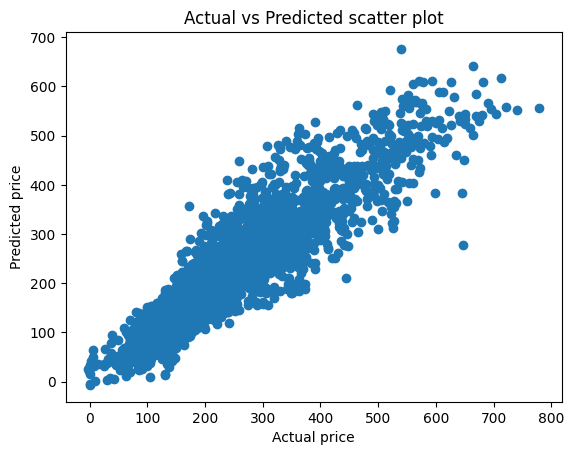

In [36]:
Rsq_train = linreg.score(X_train, y_train)
print("R square on training data: {}".format(round(Rsq_train,2)))
Rsq = linreg.score(X_test, y_test)
print("R square on testing data: {}".format(round(Rsq,2)))
adj_r2 = (1 - (1 - Rsq_train) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adj. R square on training data: {} %".format(round(adj_r2*100,2)))
adj_r2 = (1 - (1 - Rsq) * ((X_test.shape[0] - 1) / 
          (X_test.shape[0] - X_test.shape[1] - 1)))
print("Adj. R square on testing data: {} %".format(round(adj_r2*100,2)))
y_train_pred = linreg.predict(X_train)
y_pred = linreg.predict(X_test)
print("RMSE on train data: {}".format(round(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred)),2)))
print("RMSE on test data: {}".format(round(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),2)))

print('\n')
plt.scatter(x=y_test['price_second_auction'],y=y_pred);
plt.title('Actual vs Predicted scatter plot');
plt.xlabel("Actual price")
plt.ylabel("Predicted price");

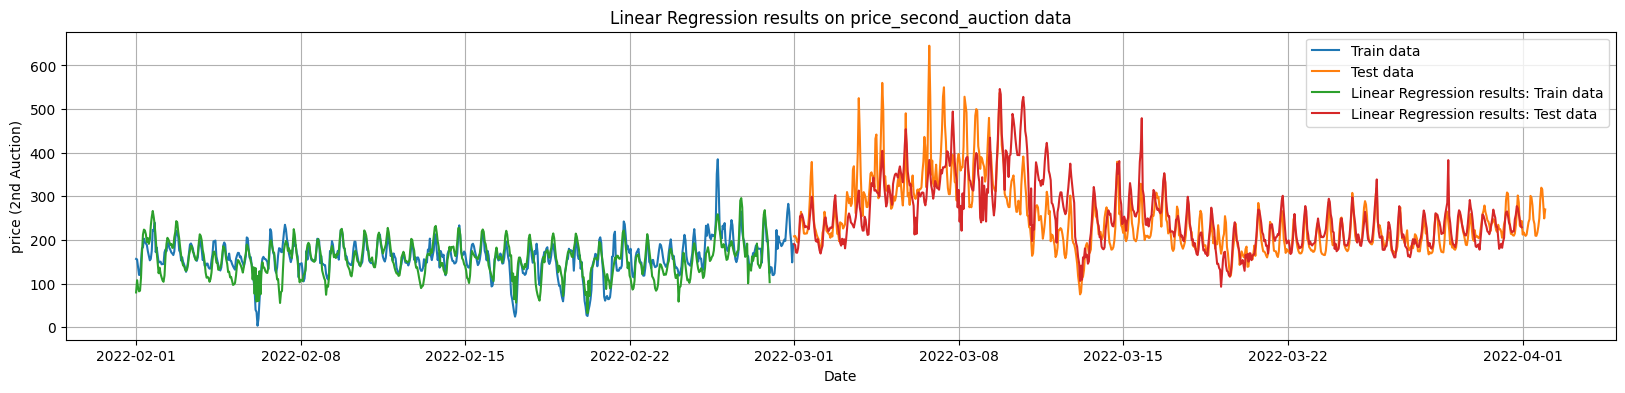

In [37]:
def plot_result(col,title,y_test_pred,y_train_pred): 
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(train[col].loc['2022-02-01':'2022-02-28'], label='Train data')
    plt.plot(test[col].loc['2022-03-01':'2022-04-01'], label='Test data')
    if len(y_train_pred)!=0:
        plt.plot(train.index[9506:10154], y_train_pred[9506:10154], label=title+": Train data")
    plt.plot(test.index[:743], y_test_pred[:743], label=title+": Test data")
    plt.legend(loc='best')
    plt.title(f"{title} on {col} data")
    plt.xlabel("Date")
    plt.ylabel("price (2nd Auction)");
plot_result('price_second_auction','Linear Regression results',y_pred,linreg.predict(X_train))

In [38]:
def smape(Actual, Forcasted):
    return 100/len(Actual) * np.sum(2 * np.abs(Forcasted - Actual) / (np.abs(Actual) + np.abs(Forcasted)))

round(smape(test['price_second_auction'].values,  y_pred.ravel()),2)

np.float64(17.1)

In [39]:
auc_df = auc_df.set_index('Date (WET)') 
auc_df = auc_df[~auc_df.index.duplicated()]
for_df = for_df[~for_df.index.duplicated()]
print(f"rows in forecasting data: {for_df.shape[0]}")
print(f"rows in auction data: {auc_df.shape[0]}")

rows in forecasting data: 14878
rows in auction data: 14878


In [40]:
auc_df['price_forecast_second_auction'] = linreg.predict(for_df[feature_col_names])
auc_df.head()

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction
Date (WET),,,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.956097
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.893960
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.561914
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.683111
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.643551
